# Solutions Tutorial 2: Quantum Gates

##### After going through this 1 hour tutorial you will:

- understand pyQuil's wavefunction functionality
- be able to visualize quantum states on the Bloch sphere
- understand quantum gates on the Bloch sphere
- be able to use pyQuil to create shallow circuits
- know how to use quantum gate identities to simplify circuits

First we need to install [QuTiP](http://qutip.org/) which is a Python toolbox for quantum physicists. We will use it to plot quantum states on the Bloch sphere. If you haven't work with or heard of QuTiP yet then you should definitely check it out (not now though). We also install Cython and pyQuil to be on the safe side.

In [ ]:
!pip install cython numpy qutip
!pip install pyquil

Next we need to make sure that we set up our API key & user ID in order to be able to use Rigetti's servers.

In [ ]:
import os

API_KEY = 'YOUR API KEY GOES HERE'
USER_ID = 'YOUR USER ID GOES HERE'

PYQUIL_CONFIG = f"""
[Rigetti Forest]
url: https://api.rigetti.com/qvm
key: {API_KEY}
user_id: {USER_ID}
"""

with open(os.path.expanduser('~/.pyquil_config'), 'w') as f:
    f.write(PYQUIL_CONFIG)

***
## 1. The Bloch sphere

In the [standard quantum computing literature](https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwifzcXS743cAhXs6YMKHX9WCXkQFggqMAA&url=http%3A%2F%2Fwww-reynal.ensea.fr%2Fdocs%2Fiq%2FQC10th.pdf&usg=AOvVaw2C4NgLeXUf1P_DLxSk85_e) we usually write a single qubit as:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\ket{\psi} = e^{i\gamma} \big( \, \alpha \ket{0} + \beta \ket{1}\,\big)$$

We know that the probability of measuring the $\ket{0}$ state is given by the absolute value of its amplitude squared:

$$|e^{i\gamma}\alpha|^2 = e^{i\gamma}\alpha e^{-i\gamma}\alpha^\dagger = e^{i\gamma - i\gamma} \alpha \alpha^\dagger = \alpha \alpha^\dagger$$

This leads to the important observation that the global phase of $e^{i\gamma}$ has no impact on the final probability and thus *global phases can always be ignored since they are immeasurable quantities*.

However, in order to visualize single-qubit states we need to express the qubit amplitudes in the following form:

$$\ket{\psi} = \cos(\frac{\theta}{2}) \ket{0} + e^{i\phi}\sin(\frac{\theta}{2}) \ket{1}$$
where
$$0 \leq \theta \leq \pi$$ and $$0 \leq \phi < 2\pi$$.

From this expression we can obtain the three Cartesian coordinates:

$$x = \sin(\theta)\cos(\phi)$$
$$y = \sin(\theta)\sin(\phi)$$
$$z = \cos(\theta)$$

which can be plotted on the three-dimensional unit 2-sphere, also called Bloch sphere which looks like this:

In [ ]:
from qutip import Bloch

# Initialize an empty Bloch sphere
bloch_sphere = Bloch()
bloch_sphere.show()

#### Exercise 1.0: 
If you haven't worked with the Bloch sphere before, read about it briefly (!) on [Wikipedia](https://en.wikipedia.org/wiki/Bloch_sphere) and read page 15 in [Nielsen & Chuang](https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwifzcXS743cAhXs6YMKHX9WCXkQFggqMAA&url=http%3A%2F%2Fwww-reynal.ensea.fr%2Fdocs%2Fiq%2FQC10th.pdf&usg=AOvVaw2C4NgLeXUf1P_DLxSk85_e). What does it mean if a quantum state vector lies on the equator of the sphere?

Write answer here:

***

Here we define two useful functions related to the Bloch sphere that we will need later on. The first one eliminates the global phase and computes $x, y, z$ from $\alpha$ and $\beta$. The second function simply plots a given amplitude vector on the Bloch sphere using the QuTiP library. 

In [ ]:
import cmath
import numpy as np

def get_vector(alpha, beta):
    """
    Function to compute 3D Cartesian coordinates
    from 2D qubit vector.
    """

    # get phases
    angle_alpha = cmath.phase(alpha)
    angle_beta = cmath.phase(beta)
    
    # avoiding wrong normalization due to rounding errors
    if cmath.isclose(angle_alpha, cmath.pi):
        angle_alpha = 0
    if cmath.isclose(angle_beta, cmath.pi):
        angle_beta = 0

    if (angle_beta < 0 and angle_alpha < angle_beta) or (angle_beta > 0 and angle_alpha > angle_beta):
            denominator = cmath.exp(1j*angle_beta)
    else:
            denominator = cmath.exp(1j*angle_alpha)

    # eliminate global phase
    alpha_new = alpha/denominator
    beta_new = beta/denominator

    # special case to avoid division by zero
    if abs(alpha) == 0 or abs(beta) == 0:
        if alpha == 0:
            return [0,0,-1]
        else:
            return [0,0,1]
    else:
        # compute theta and phi from alpha and beta
        theta = 2*cmath.acos(alpha_new)
        phi = -1j*cmath.log(beta_new/cmath.sin(theta/2))

        # compute the Cartesian coordinates
        x = cmath.sin(theta)*cmath.cos(phi)
        y = cmath.sin(theta)*cmath.sin(phi)
        z = cmath.cos(theta)

    return [x.real,y.real,z.real]

def plot_quantum_state(sphere, amplitudes):
    """
    Thin function to abstract the plotting on the Bloch sphere.
    """
    bloch_sphere = Bloch()
    vec = get_vector(amplitudes[0], amplitudes[1])
    bloch_sphere.add_vectors(vec)
    bloch_sphere.show()
    bloch_sphere.clear()

***
## 2. pyQuil's wavefunction

Rigetti initializes all their qubits in the $\ket{0}$ state. Let's verify this by running a simple pyQuil program and visualizing the resulting quantum state on the Bloch sphere.

#### Exercise 2.0: 
Read the pyQuil docs and learn how to obtain the wavefunction and its amplitudes to visualize the initial qubit state on the Bloch sphere.

In [ ]:
from pyquil.api import QVMConnection
from pyquil.quil import Program

# initialize a QVMConnection with Rigetti's server
qvm = QVMConnection()

# initialize a pyQuil program that measures the initial qubit state
p = Program()
p.measure(0, 0)

# TODO: find out how to get the resulting wavefunction + amplitudes after running the program in the QVM
wavefunction = qvm.wavefunction(p)
amplitudes = wavefunction.amplitudes

# now we can call our custom function to plot the quantum state
plot_quantum_state(bloch_sphere, amplitudes)

pyQuil's Wavefunction has a lot of very helpful functionalities like obtaining probabilities from amplitudes, plotting as well as pretty printing them. 

#### Exercise 2.1:
Explore pyQuil's wavefunction functionalities. Plot and pretty print the probabilities!

In [ ]:
# TODO: Try getting the probabilities from a wavefunction object and plot & pretty print the result!

print('Plotting the probabilities:')
wavefunction.plot()

print('Pretty printing the wavefunction: \n')
print(f'{wavefunction.pretty_print()} \n')

print('Pretty printing the probabilities: \n')
print(wavefunction.pretty_print_probabilities())

***
## 3. The Hadamard gate

In the previous tutorial you've already familiarized yourself with a really important quantum gate: the Hadamard gate. In Dirac notation the H gate corresponds to the matrix given by:

$$H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}$$

The Hadamard is an essential ingredient to create quantum superposition states. In the following exercises you will further explore it's use cases and intricacies.

#### Exercise 3.0:
Import and apply the Hadamard gate one time and observe how the plot of the probability distribution changes! What do you observe?

In [ ]:
#TODO: import the Hadamard gate
from pyquil.gates import H

p = Program()
# apply the Hadamard gate to qubit 0 once
p.inst(H(0))

# TODO: get the wavefunction from the QVM 
# and plot the probability distribution
wavefunction = qvm.wavefunction(p)
wavefunction.plot()

#### Exercise 3.1:
In three different experiments, apply the Hadamard gate two, three, and four times in sequence and observe how the probability distribution changes! What do you observe?

In [ ]:
for i in range(2, 5):
    # TODO: apply the Hadamard gate multiple times
    p = Program(H(0) for k in range(i))
    
    # TODO: get the wavefunction from the QVM 
    # and plot the probability distribution
    wavefunction = qvm.wavefunction(p)
    print(f'Probabilities after applying H {i} times:')
    wavefunction.plot()

***
## 4. Pauli gates on the Bloch sphere

#### Exercise 4.0:
Explore the action of the Pauli gates (Identity, $X$, $Y$, $Z$) on the Bloch sphere. <a title="Try using a H gate first to move the Bloch vector onto the equator and then apply the X, Y or Z gate to observe the rotation. Also try applying an H gate and an S gate to move the initial vector onto the y axis.">Hint.</a>

In [ ]:
# TODO: import the Pauli gates (Identity, X, Y, Z).
from pyquil.gates import I, X, Y, Z

def apply_pauli_gates(initial_state, state_name):
    """
    Given a program that initializes an initial state this function
    will apply each Pauli gate once and plot the resulting state
    on the Bloch sphere.
    """
    
    for pauli_gate in [I(0), X(0), Y(0), Z(0)]:
        p = Program()
        p.inst(pauli_gate)
        p = initial_state + p
        amplitudes = qvm.wavefunction(p).amplitudes
        print(f"{pauli_gate.name}'s action on the {state_name} state:")
        plot_quantum_state(bloch_sphere, amplitudes)

# TODO: try I, X, Y, Z on different initial quantum states!

from pyquil.gates import H, S # needed to get initial state to x or y axis

# |+z> = |0>
apply_pauli_gates(Program(), '|+z>')

# |-z> = |1>
apply_pauli_gates(Program(X(0)), '|-z>')

# |+x> = 0.707 |0> + 0.707 |1>
apply_pauli_gates(Program(H(0)), '|+x>')

# |-x> = 0.707 |0> - 0.707 |1>
apply_pauli_gates(Program(X(0), H(0)), '|-x>')

# |+y> = 0.707 |0> + 0.707i |1>
apply_pauli_gates(Program(H(0), S(0)), '|+y>')

# |-y> = 0.707 |0> - 0.707i |1>
apply_pauli_gates(Program(X(0), H(0), S(0)), '|-y>')

#### Exercise 4.1:
How many degrees around which axis do the Pauli gates rotate the Bloch vector? Make sure to also try other initial states (e.g. Bloch vector on $x$, $-x$, $y$ or $-y$ axis)!

Write answer here:

- Identity: no rotation
- X: 180 degrees around the X axis
- Y: 180 degrees around the Y axis
- Z: 180 degress around the Z axis

#### Exercise 4.2:
pyQuil has many different ways of defining a quantum program. Read the docs and try it below (print the final programs to understand the effect):

In [ ]:
# TODO: Try out different possibilities of chaining instructions

# try putting multiple gates into a single .inst() call
p = Program()
p.inst(H(0), H(1), H(2))
print(f'Many gates in one .inst() call:\n{p} \n')

# chain multiple .inst() call after each other and add a final MEASURE or .measure statement
p = Program()
p.inst(H(0)).inst(H(1)).inst(H(2)).measure(0,0)
print(f'Chained .inst() calls:\n{p} \n')

# try to mix the two possibilities above
p = Program()
p.inst(H(0)).inst(H(1), H(2)).measure(0,0)
print(f'Mixing the two:\n{p} \n')

# use a Python generator to populate a Program
p = Program()
p.inst(H(i) for i in range(3))
print(f'With generator:\n{p} \n')

# define three programs and then ADD them together and print it. What do you observe?
p0 = Program().inst(H(0))
p1 = Program().inst(H(1))
p2 = Program().inst(H(2))
p = p0 + p1 + p2
print(f'With addition:\n{p} \n')

#### Exercise 4.3:
Use the last program from the previous exercise and try calling the `.pop()` function. Print the program again. What do you observe?

In [ ]:
# TODO: Use .pop() on the last program from Ex. 4.4
print(f'Before .pop():\n{p}')
p.pop()
print(f'After .pop():\n{p}')

# Observation: it pops/deletes the last quantum gate in the Program

***
## 5. Quantum gate identities

Current quantum computers only allow shallow depth circuits since the qubits decohere too quickly. Thus, it is extremely important to keep your circuits small! In this section you will use pen & paper to learn how to manually simplify quantum circuits.

By the way, there is a lot of people (including Rigetti staff) working on automating this task. They are working on developing more efficient and better **quantum compiler**. If you're interested in diving deeper in quantum gate identities than consider tackling Bonus Exercise 7.6!

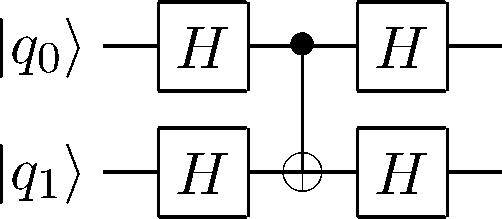

#### Pen & Paper Exercise 5.0
Go through the math of the quantum circuit shown above by explicitly multiplying the matrices. What does this circuit reduce to? <a title="You have to take the tensor product H x H (numpy.kron) in order to get a 4x4 matrix.">Hint.</a>

Write your answer here: It reduces to a CNOT with source and target qubit interchanged.

***
## 6. Notation in quantum computing

#### Exercise 6.0:
Write a short pyQuil program which implements an $X$ gate on qubit $0$ and an identity gate on qubit $1$. BEFORE you print the wavefunction, write down what qubit string you expect. Then contrast it with the result. Did you expect it? Why or why not? Check out Bonus Exercise 7.5 for explanation.

In [ ]:
from pyquil.gates import X, I

p = Program()

# TODO: implement an X gate on qubit 0 and an identity gate on qubit 1
p.inst(X(0), I(1))

# TODO: print the wavefunction
print(qvm.wavefunction(p))

# Observation: the qubits are ordered in reverse |q_N,..., q_1, q_0>

***
## 7. Bonus exercises

#### Bonus Exercise 7.0:
pyQuil comes with a lot of already implemented quantum gates. In this exercise it is your goal to manually implement your own single qubit gate. Try to define the following gate manually:
$U =  \begin{bmatrix}
e^{i\frac{2}{3}\pi} & 0 \\
0 & e^{-i\frac{2}{3}\pi}
\end{bmatrix}$

In [ ]:
# TODO: Implement custom single-qubit rotation with pyQuil

# implementing u
u = np.array([[cmath.exp(1j*(2/3)*cmath.pi), 0], [ 0, cmath.exp(-1j*(2/3)*cmath.pi)]])

# define the new gate
p = Program().defgate("U", u)

# now we can use it in a Program
p.inst(("U", 0))

print(qvm.wavefunction(p))

#### Bonus Exercise 7.1:
There is many more elementary quantum gates than just Pauli gates! Try out the $T$ and $S$ gates and find out which rotations they correspond to. You might want to quickly read up on them in [Nielsen & Chuang](https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwifzcXS743cAhXs6YMKHX9WCXkQFggqMAA&url=http%3A%2F%2Fwww-reynal.ensea.fr%2Fdocs%2Fiq%2FQC10th.pdf&usg=AOvVaw2C4NgLeXUf1P_DLxSk85_e).

In [ ]:
# TODO: import the T and S gate
from pyquil.gates import T, S

initial_state = Program().inst(H(0))
amplitudes = qvm.wavefunction(initial_state).amplitudes

print("Initial state (|+>):")
plot_quantum_state(bloch_sphere, amplitudes)

# TODO: try T and S on different initial quantum states!

# testing the S gate
p = Program()
p.inst(S(0))
p = initial_state + p
amplitudes = qvm.wavefunction(p).amplitudes

print("S gate's action on the |+> state:")
plot_quantum_state(bloch_sphere, amplitudes)

# testing the T gate
p = Program()
p.inst(T(0))
p = initial_state + p
amplitudes = qvm.wavefunction(p).amplitudes

print("T gate's action on the |+> state:")
plot_quantum_state(bloch_sphere, amplitudes)

#### Bonus Exercise 7.2:
What rotations on the Bloch sphere do the T and S gate correspond to?

Write answer here:

- S gate rotates 90 degrees around the Z axis
- T gate rotates 45 degrees around the Z axis

#### Bonus Exercise 7.3:
How would you describe the rotation of the Hadamard gate on the Bloch sphere? How many degrees around which axis? Make sure to not just check how it acts on the $\ket{0}$ or $\ket{1}$ state! Try for example to prepare the state $$\ket{\psi} = \frac{1}{\sqrt{2}}\ket{0} + \frac{i}{\sqrt{2}}\ket{1}$$ (y-axis on Bloch sphere) and then act the H gate on it.

Write answer here:

- The Hadamard gate rotates 180 degrees around the Z+X axis
- You can also visualize it as a 90 degree rotation around Y followed by a 180 degree rotation around X 

#### Bonus Exercise 7.4:
Read the pyQuil docs and learn about parametric gates. Then try to manually create a parametrized controlled U gate with:

$$U =  \begin{bmatrix}
1 & 0 \\
0 & e^{i\phi}
\end{bmatrix}$$

In [ ]:
from pyquil.parameters import Parameter, quil_exp
from pyquil.quilbase import DefGate
from pyquil.gates import X
# TODO: Manually create a parametric controlled U gate

phi = Parameter('phi')
u = np.array([[1, 0], [0, quil_exp(1j*phi)]])

dg = DefGate('U', u, [phi])
U = dg.get_constructor()

p = Program()
p.inst(dg) # register the new gate

p.inst(X(0))
p.inst(U(cmath.pi/4)(0)) # use the new gate

print(qvm.wavefunction(p))

#### Bonus Exercise 7.5:
Read the paper with the title ['Someone shouts, “$\ket{01000}$!” Who is excited?'](https://arxiv.org/pdf/1711.02086.pdf) by Rigetti staff member Robert Smith to gain a deeper understanding why we label qubits the reverse way ($\ket{q_N, ..., q_1, q_0}$ rather than $\ket{q_0, ..., q_{N-1}, q_N}$).

#### Bonus Pen & Paper Exercise 7.6:
Consider the quantum circuit below. Use [this paper](https://arxiv.org/pdf/quant-ph/0307111.pdf) and other sources to simplify and condense the quantum circuit as much as possible.

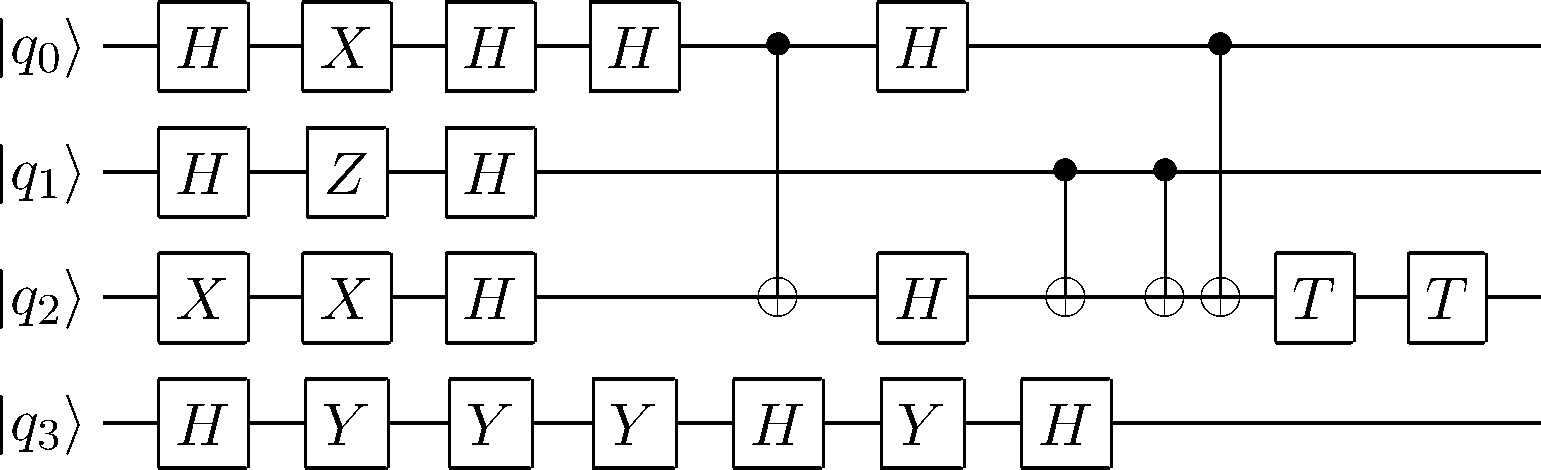

This circuit can be reduced to:

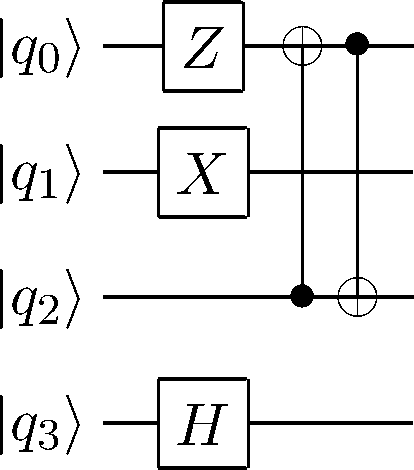

by using the following identities:

$$XX = \mathbb{1}$$
$$YY = \mathbb{1}$$
$$ZZ = \mathbb{1}$$
$$HXH = Z$$
$$HZH = X$$
$$HYH = -Y$$
$$\text{Two consecutive CNOTs} = \mathbb{1}$$
$$\text{CNOT surrounded with Hadamards} = \text{inverted CNOT}$$